**Table of contents**<a id='toc0_'></a>    
- 1. [AS-AD for an open economy](#toc1_)    
- 2. [Analytical solution](#toc2_)    
- 3. [Numerical solution and calibration of model](#toc3_)    
- 4. [Further analysis (ideas)](#toc4_)    
- 5. [Conclusion](#toc5_)    


In [3]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from test_chris import ASADClass 

## 1. <a id='toc1_'></a>[AS-AD for an open economy](#toc0_)


In our model project, we model the the AS-AD model for an small, open economy,  first with a fixed exchange rate and second with a floating exchange rate.

Firstly, we define **output and inflation gaps**:


1. **Output gap:** $$\hat{y}_{t} = y_t-\bar{y}$$
2. **Inflation gap:** $$\hat{\pi}_{t} = \pi_t-\pi^{\ast}$$

The model equations are given by the following:
1. **1 - AD-curve under fixed exchange rates:** $$\hat{y}_{t} = \beta_1 (e^r_{t-1}-\hat{\pi}_{t}) + z_t \Leftrightarrow$$
$$\hat\pi_t = e^r_{t-1}-\frac{1}{\beta_1}\hat{y}_t+\frac{z_t}{\beta_1} $$

1. **2 - AD-curve under floating exchange rates:** $$\hat{y}_{t} = \beta_1 e^r_{t-1}-\hat{\beta_1}\hat\pi_t + z_t \Leftrightarrow$$
$$\hat\pi_t = \frac{\beta_1}{\hat{\beta_1}} e^r_{t-1}-\frac{1}{\hat{\beta_1}} \hat{y}_t+\frac{z_t}{\hat{\beta_1}} $$ 
$$where\  \hat\beta_1 = \beta_1 + h\left(\frac{\beta_1}{\theta}+\beta_2\right)>\beta_1$$

2. **Short-Run AS curve:** $$\hat{\pi}_{t} = \gamma \hat{y}_{t}+ s_t$$

3. **Real Exchange rate:** $$ e^r_t = e^r_{t-1}-\hat\pi_t$$

4. **Demand shock:** $$z_{t} = \delta z_{t-1}+x_{t}, x_{t} \sim N(0,\sigma_x^2)$$

5. **Supply shock:** $$s_{t} = \omega s_{t-1}+c_{t}, c_{t} \sim N(0,\sigma_c^2)$$

It can be seen above that the economy with a fixed and floating exchange rate are equal when h = 0, as then $\hat\beta_1 = \beta_1$.


## The floating exchange rate economy
The model can be rewritten by firstly inserting AS in AD and isolating for $e_{t-1}^r$:

$$
\hat{y}_t = \beta_1 e_{t-1}^r - \hat\beta_1 \gamma \hat{y}_t - \hat\beta_1 s_t + z_t \Leftrightarrow $$


$$
e_{t-1}^r = \frac{1+\hat\beta_1 \gamma}{\beta_1} \hat{y}_t + \frac{\hat\beta_1}{\beta} s_{t}-\frac{1}{\beta_1} z_t
$$

Inserting this in the exchange rate as well as AS we have:

$$
\frac{1+\hat\beta_1 \gamma}{\beta_1} \hat{y}_{t} + \frac{\hat\beta_1}{\beta} s_{t} - \frac{1}{\beta_1} z_{t} = \frac{1+\hat\beta_1 \gamma}{\beta_1} \hat{y}_{t-1} + \frac{\hat\beta_1}{\beta_1} s_{t-1} - \frac{1}{\beta_1} z_{t-1} - \gamma \hat{y}_{t-1} - s_{t-1} \Leftrightarrow
$$

$$
\frac{1+\hat\beta_1 \gamma}{\beta_1} \hat{y}_{t} = \frac{1+\gamma(\hat\beta_1-\beta_1)}{\beta_1} \hat{y}_{t-1} + \frac{1}{\beta_1} (z_{t} - z_{t-1}) -\frac{\hat\beta_1}{\beta_1} \left(s_{t}-s_{t-1}\left(1-\frac{\beta_1}{\hat\beta_1}\right)\right) \Leftrightarrow
$$

$$
\hat{y}_t = a(1+b)\hat{y}_{t-1} + a(z_t - z_{t-1}) - a\left(\hat\beta_1 s_{t}-s_{t-1}({\hat\beta_1-\beta_1})\right) \quad \text{(*)}
$$

Repeating the same steps for the inflation gap gives:

$$
\hat{\pi}_t = a(1+b)\hat{\pi}_{t-1} + a (s_t - s_{t-1}) + a\gamma(z_t - z_{t-1}) \quad \text{(**)}
$$

where 

$$
a = \frac{1}{1+\beta_1 \gamma}
$$
$$
b = \gamma(\hat\beta_1-\beta_1)
$$



## The fixed exchange rate economy
The model for the fixed exchange rate is a special case of the floating exchange rate economy, which is found by setting $\hat\beta_1 = \beta_1$. The model for the fixed exchange rate economy is:

$$
\hat{y}_t = a\hat{y}_{t-1} + a(z_t - z_{t-1}) - a\beta_1 s_t \quad \text{(***)}
$$

$$
\hat{\pi}_t = a \hat{\pi}_{t-1} + a (s_t - s_{t-1}) + a\gamma(z_t - z_{t-1}) \quad \text{(****)}
$$



In [4]:
model = ASADClass(fixed=False)
par = model.par
sim = model.sim
print(f'{par.a = :.4f}')
print(f'{par.b = :.4f}')

par.a = 0.7583
par.b = 0.2662


## 2. <a id='toc2_'></a>[Calibration](#toc0_)

We want to calibrate our ASAD model so that it best fits real business cycle data. First, we simulate the model with 10.000 periods and plot the first 100 periods. For this simulation we calculate the moments such as standard deviation and the correlation between output and inflation gap.

In [5]:
model.simulate()

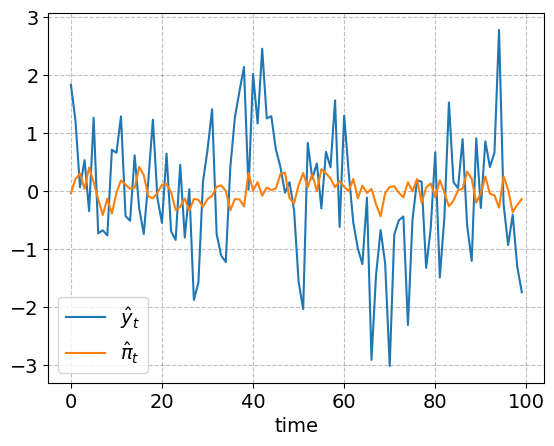

In [6]:
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

We now want to compare the model moments with the real business cycle data for Denmark. In **business-cycle data** from Denmark we have:
* Change data to denmark
1. $std(\hat{y}_t) = 1.64$
2. $std({\hat{\pi}}_t) = 0.21$
3. $corr(\hat{y}_t,{\hat{\pi}}_t) = 0.31$
4. $corr(\hat{y}_t,\hat{y}_{t-1}) = 0.84$
5. $corr({\hat{\pi}}_t,{\hat{\pi}}_{t-1}) = 0.48$

We define the error as the sum of squared distances between model and the data.
$$
\begin{align*}
error(\delta,\omega,\sigma_x,\sigma_c) = &\,\,(std(\hat{y}_t^{data}) - std(\hat{y}_t^{model}))^2 \\
& + (std({\hat{\pi}}_t^{data}) - std({\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},{\hat{\pi}}_t^{data}) - corr(\hat{y}_t^{data},{\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},\hat{y}_{t-1}^{data}) - corr(\hat{y}_t^{model},\hat{y}_{t-1}^{model}))^2 \\
& + (corr({\hat{\pi}}_t^{data},{\hat{\pi}}_{t-1}^{data}) - corr({\hat{\pi}}_t^{model},{\hat{\pi}}_{t-1}^{model}))^2 \\
\end{align*}
$$

**The goal** is the change the autocorrelation and variance of the shocks so that the model best fits the Danish data. That is
$$
\min_{\delta,\omega,\sigma_x,\sigma_c} error(\delta,\omega,\sigma_x,\sigma_c)
$$

Below the objective function which simulates the model for given parameters and spits out the error has been defined

In [7]:
def obj(x,parnames,do_print=False):
    """ objective for choosing parameters """

    # a. update parameters
    for xval,parname in zip(x,parnames):
        par.__dict__[parname] = xval
        if do_print: print(f'{parname:10s} = {xval:.4f}')

    if do_print: print('')

    model.calc_compound_par()

    # b. simulate and calculate moments
    model.simulate()
    model.calc_moms()

    # c. compare with data
    error = model.calc_diff_to_data(do_print=do_print)

    return error

For the simulation with arbitrarly chosen parameters we have the followin error:

In [8]:
parnames = ['delta','omega','sigma_x','sigma_c']
x0 = [par.__dict__[parname] for parname in parnames]
error_ = obj(x0,parnames,do_print=True)

delta      = 0.8000
omega      = 0.1500
sigma_x    = 1.0000
sigma_c    = 0.2000

std_y       | data = 1.6400, model = 1.4098
std_pi      | data = 0.2100, model = 0.1781
corr_y_pi   | data = 0.3100, model = 0.0397
autocorr_y  | data = 0.8400, model = 0.6659
autocorr_pi | data = 0.4800, model = 0.2803
error =   0.19727604


We call the optimizer to minimize the error function where the AR coefficient is bound between 0 and 1 to remain stationary while the variance is bounded only by zero.

In [9]:
bounds = ((0,1-1e-8),(0,1-1e-8),(0,None),(0,None))
res = optimize.minimize(obj,x0,bounds=bounds,method='Nelder-Mead',args=(parnames,))

In [10]:
error_ = obj(res.x,parnames,do_print=True)

delta      = 0.9546
omega      = 0.2334
sigma_x    = 0.8000
sigma_c    = 0.1744

std_y       | data = 1.6400, model = 1.6437
std_pi      | data = 0.2100, model = 0.1750
corr_y_pi   | data = 0.3100, model = 0.3070
autocorr_y  | data = 0.8400, model = 0.8412
autocorr_pi | data = 0.4800, model = 0.4786
error =   0.00124917


In [12]:
model.par

namespace(beta=0.7,
          gamma=0.075,
          beta_2=0.1,
          theta=0.1,
          h=0.5,
          delta=0.9545520153808174,
          omega=0.2334159093881469,
          sigma_x=0.7999830480446478,
          sigma_c=0.1744382962845269,
          simT=10000,
          beta_hat=4.249999999999999,
          a=0.7582938388625593,
          b=0.26624999999999993)

Here we have calibrated the model which leads to a much smaller error and moments which are quite close to the business cycle data. The optimal parameters suggest that demand shocks are highly autocorrelated while supply shocks are less so. Demand is also more volatile than inflation. These results seem reasonable.

## 3. <a id='toc3_'></a>[Simulate](#toc0_)

We now simulate our calibrated model.


In [13]:
model.simulate()

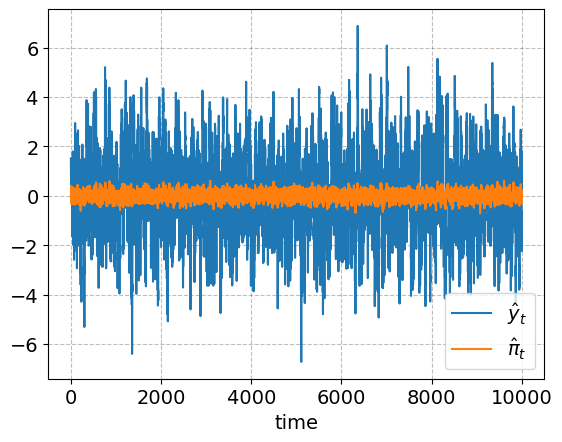

In [15]:
simT_fig = 10000 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

## 4. <a id='toc4_'></a>[Further analysis (ideas)](#toc0_)

Impulse response to demand or supply shock. Errors are zero for all t.

Difference between y and y_hat for periods 1 to T. 

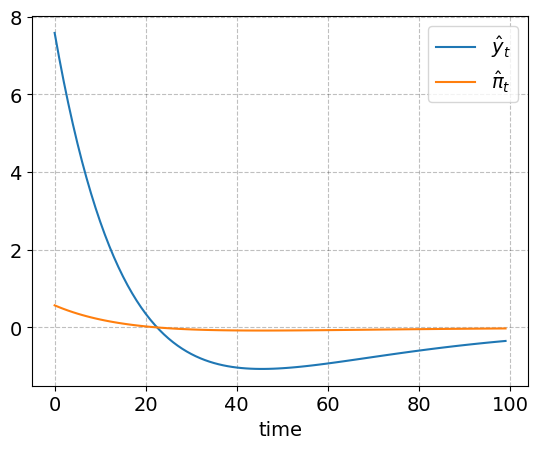

In [18]:
model.impulse_response(demand=True)
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

Graphical analysis

## 5. <a id='toc5_'></a>[Conclusion](#toc0_)